In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report,accuracy_score


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# loading the dataset
columns=['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'context']
train_data = pd.read_csv('/kaggle/input/lairfi/train.tsv', sep='\t', header=None, names=columns,index_col=False)
test_data = pd.read_csv('/kaggle/input/lairfi/test.tsv', sep='\t', header=None, names=columns,index_col=False)
valid_data = pd.read_csv('/kaggle/input/lairfi/valid.tsv', sep='\t', header=None, names=columns,index_col=False)

In [3]:
#making 6 class classification into binary classification and class balancing
def preprocess_dataset(dataset):
    # Create a new 'label' column based on the original labels
    dataset['label'] = dataset['label'].apply(lambda x: 1 if x in ['true', 'mostly-true'] else 0)
    dataset = dataset.drop(columns=['id', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire'])
    metadata_columns = ['subject', 'speaker', 'job', 'state', 'party', 'context']
    dataset[metadata_columns] = dataset[metadata_columns].apply(lambda col: col.replace(0, 'None'))
    dataset['meta'] = dataset[metadata_columns].astype(str).agg(' '.join, axis=1)
    dataset['sentence'] = dataset['meta'] + ' ' + dataset['statement'].astype(str)
    dataset = dataset.drop(columns=metadata_columns + ['meta'])
    # Drop rows with null values
    dataset = dataset.dropna()
    # Convert to PyTorch tensors
    # labels = torch.tensor(dataset['label'].values)
    # sentences = torch.tensor(dataset['sentence'].values, dtype=torch.string)
    return dataset

train_data = preprocess_dataset(train_data)
valid_data = preprocess_dataset(valid_data)
test_data = preprocess_dataset(test_data)

In [4]:
train_data.head()

,label,statement,sentence
0,0,Says the Annies List political group supports ...,abortion dwayne-bohac State representative Tex...
1,0,When did the decline of coal start? It started...,"energy,history,job-accomplishments scott-surov..."
2,1,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy barack-obama President Illinois...
3,0,Health care reform legislation is likely to ma...,health-care blog-posting nan nan none a news r...
4,0,The economic turnaround started at the end of ...,"economy,jobs charlie-crist nan Florida democra..."


In [5]:
X_train = train_data['statement']
y_train = train_data['label']
X_test = test_data['statement']
y_test = test_data['label']
X_valid = valid_data['statement']
y_valid = valid_data['label']
X_train[0]


'Says the Annies List political group supports third-trimester abortions on demand.'

In [6]:
X_train = X_train.values.tolist()
y_train = y_train.values.tolist()
X_test = X_test.values.tolist()
y_test = y_test.values.tolist()
X_valid = X_valid.values.tolist()
y_valid = y_valid.values.tolist()

In [7]:
!pip install transformers

In [8]:
# Tokenization using bert tokenizer
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize the sentences
X_train = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_test = tokenizer(X_test, padding=True, truncation=True, max_length=512)
X_valid = tokenizer(X_valid, padding=True, truncation=True, max_length=512)

# X_train = [tokenizer(sent, padding=True, truncation=True, max_length=256) for sent in X_train]
# X_test = [tokenizer(sent, padding=True, truncation=True, max_length=256) for sent in X_test]
# X_valid = [tokenizer(sent, padding=True, truncation=True, max_length=256) for sent in X_valid]


In [9]:
# labels = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']
# y_train = [labels.index(s) for s in y_train]
# y_test = [labels.index(s) for s in y_test]
# y_valid = [labels.index(s) for s in y_valid]
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
y_valid = torch.tensor(y_valid)




In [10]:
# dataloader
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(torch.tensor(X_train['input_ids']), torch.tensor(X_train['attention_mask']), y_train)
test_dataset = TensorDataset(torch.tensor(X_test['input_ids']), torch.tensor(X_test['attention_mask']))
valid_dataset = TensorDataset(torch.tensor(X_valid['input_ids']), torch.tensor(X_valid['attention_mask']), y_valid)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=True)


In [11]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2)

optimizer = optim.AdamW(model.parameters(), lr = 1e-3, eps = 1e-8)
from transformers import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = len(train_dataloader) * 2
)

#  loss function
loss_fn = nn.BCELoss()

# evaluation metric
def accuracy(preds, labels):
    preds = preds.argmax(dim=1, keepdim=True)
    correct = preds.eq(labels.view_as(preds)).sum()
    acc = correct.float()/labels.shape[0]
    return acc


#  training parameters
epochs = 5
total_steps = len(train_dataloader) * epochs
warmup_steps = math.ceil(total_steps * 0.1)
print("Total steps: ", total_steps)
print("Warmup steps: ", warmup_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# train the model
best_acc = 0
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch+1, epochs))
    start_time = time.time()
    # training loop
    model.train()
    train_losses_epoch = []
    train_accs_epoch = []
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_attn_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_attn_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses_epoch.append(loss.item())
        acc = accuracy_score(b_labels.cpu(), logits.argmax(dim=1).cpu())
        train_accs_epoch.append(acc)
        if step % 100 == 0:
            print("Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}".format(step, len(train_dataloader), loss.item(), acc))
            
    # evaluation loop
    model.eval()
    valid_losses_epoch = []
    valid_accs_epoch = []
    for step, batch in enumerate(valid_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_attn_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_attn_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        valid_losses_epoch.append(loss.item())
        acc = accuracy_score(b_labels.cpu(), logits.argmax(dim=1).cpu())
        valid_accs_epoch.append(acc)
    
    
    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time-start_time, 60)
    print("Epoch took: {}m {}s".format(epoch_mins, epoch_secs))
    train_loss = np.mean(train_losses_epoch)
    train_acc = np.mean(train_accs_epoch)
    valid_loss = np.mean(valid_losses_epoch)
    valid_acc = np.mean(valid_accs_epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    print("Train loss: {:.4f}, Train acc: {:.4f}".format(train_loss, train_acc))
    print("Valid loss: {:.4f}, Valid acc: {:.4f}".format(valid_loss, valid_acc))
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), 'best_model_state.pth')
        print("Saved the model")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total steps:  3200
Warmup steps:  320
Epoch 1/5
Step [0/640], Loss: 0.5781, Accuracy: 0.7500
Step [100/640], Loss: 0.7066, Accuracy: 0.5625
Step [200/640], Loss: 0.6992, Accuracy: 0.5000
Step [300/640], Loss: 0.5270, Accuracy: 0.8750
Step [400/640], Loss: 0.7110, Accuracy: 0.5625
Step [500/640], Loss: 0.7752, Accuracy: 0.5000
Step [600/640], Loss: 0.5454, Accuracy: 0.7500
Epoch took: 14.0m 35.665608644485474s
Train loss: 0.6820, Train acc: 0.6148
Valid loss: 0.6464, Valid acc: 0.6667
Saved the model
Epoch 2/5
Step [0/640], Loss: 0.8364, Accuracy: 0.2500
Step [100/640], Loss: 0.6641, Accuracy: 0.6250
Step [200/640], Loss: 0.6212, Accuracy: 0.6875
Step [300/640], Loss: 0.5951, Accuracy: 0.7500
Step [400/640], Loss: 0.5789, Accuracy: 0.7500
Step [500/640], Loss: 0.7990, Accuracy: 0.4375
Step [600/640], Loss: 0.6504, Accuracy: 0.6875
Epoch took: 14.0m 33.043028354644775s
Train loss: 0.6598, Train acc: 0.6354
Valid loss: 0.6351, Valid acc: 0.6713
Saved the model
Epoch 3/5
Step [0/640], Loss

In [12]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

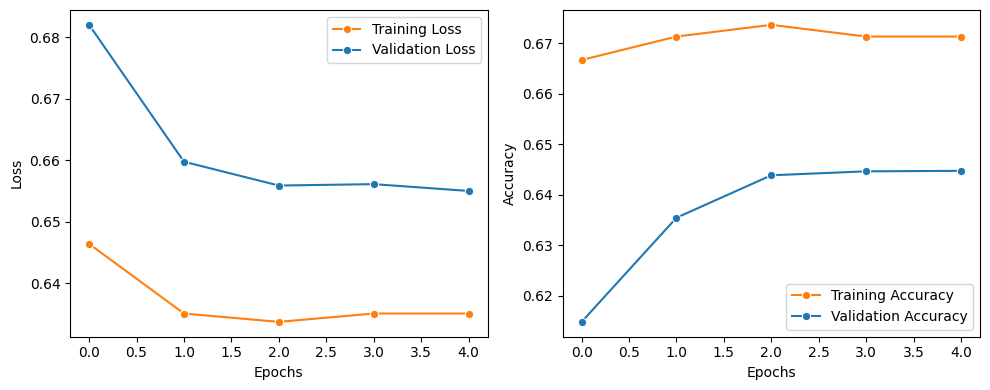

In [13]:
# plot the training curves
# plt.plot(train_losses, label='train loss')
# plt.plot(valid_losses, label='valid loss')
# plt.legend()

# plt.plot(train_accs, label='train acc')
# plt.plot(valid_accs, label='valid acc')
# plt.legend()

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, sub = plt.subplots(1, 2, figsize=(10, 4))

# Plot the data in each subplot using seaborn
sns.lineplot(train_losses, ax=sub[0],label='Training Loss', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(valid_losses, ax=sub[0], label='Validation Loss', marker='o', linestyle='-', color='tab:blue')
# sub[0].set_title('Epochs = 10')
sub[0].set_xlabel('Epochs')
sub[0].set_ylabel('Loss')

# sns.lineplot(x=epochs, y=losses_2, ax=axes[0, 1])
sns.lineplot(train_accs, ax=sub[1],label='Training Accuracy', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(valid_accs, ax=sub[1], label='Validation Accuracy', marker='o', linestyle='-', color='tab:blue')
# sub[1].set_title('Epochs = 10')
sub[1].set_xlabel('Epochs')
sub[1].set_ylabel('Accuracy')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [14]:
def predict(model, test_loader, device):
    model.eval()
    preds = []
    for step, batch in enumerate(test_loader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_attn_mask = batch
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_attn_mask)
        logits = outputs[0]
        preds.append(logits)
    preds = torch.cat(preds, dim=0)
    preds = preds.detach().cpu().numpy()
    return preds


In [2]:
# predict on test data
model.load_state_dict(torch.load('best_model_state.pth'))
test_preds = predict(model, test_dataloader, device)
test_preds = np.argmax(test_preds, axis=1)

print(accuracy_score(y_test, test_preds))

0.6556195737963694
